In [3]:
from __future__ import absolute_import, division, print_function

import math

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

print(tf.__version__)

2.4.1


In [26]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [11]:
# use pyroot for I/O
import ROOT
from ROOT import TCanvas, TPad, TFile, TPaveText
from ROOT import gBenchmark, gStyle, gROOT
def getarray(filename):
    f = TFile(filename)
    tree = gROOT.FindObject('RES')
    array = tree.AsMatrix(columns=["Enu","mumom","mucostheta","pimom","picostheta","costhetamupi","Q2","weight","pi_q","pn"])
    array11=array[array[:,8]==1]
    array11=array11[array11[:,9]==1]
    array11=array11[:,0:7]
    array11[:,0]=array11[:,0]/10**3 # unit conversion to make all numbers to be O(1)
    array11[:,1]=array11[:,1]/10**3
    array11[:,3]=array11[:,3]/10**3
    array11[:,6]=-array11[:,6]/10**6
    nGenEv = 40000000 # total number of events generated in the file, to calculate proper xsec normalization
    return array11,array[0,7]/nGenEv
array11_Eb0, w0 =getarray('/hepstore/kmtsui/T2K/NuWro/nuwro/output/RES_out_RFG_C_noPDD.root')
array11_Eb27, w27=getarray('/hepstore/kmtsui/T2K/NuWro/nuwro/output/RES_out_RFG_C_noPDD_Eb27.root')

In [16]:
# or use uproot for I/O instead
import uproot
def getarray(filename):
    f = uproot.open(filename)
    t = f["RES"]
    array = np.transpose(np.asarray(t.arrays(["Enu","mumom","mucostheta","pimom","picostheta",
                          "costhetamupi","Q2","weight","pi_q","pn"], library="np", how=tuple)))
    array11=array[array[:,8]==1]
    array11=array11[array11[:,9]==1]
    array11=array11[:,0:7]
    array11[:,0]=array11[:,0]/10**3 # unit conversion to make all numbers to be O(1)
    array11[:,1]=array11[:,1]/10**3
    array11[:,3]=array11[:,3]/10**3
    array11[:,6]=-array11[:,6]/10**6
    nGenEv = 40000000 # total number of events generated in the file, to calculate proper xsec normalization
    return array11,array[0,7]/nGenEv
array11_Eb0, w0 =getarray('/hepstore/kmtsui/T2K/NuWro/nuwro/output/RES_out_RFG_C_noPDD.root')
array11_Eb27, w27=getarray('/hepstore/kmtsui/T2K/NuWro/nuwro/output/RES_out_RFG_C_noPDD_Eb27.root')

In [12]:
len(array11_Eb0)

24681205

In [13]:
w0

4.958778378952391e-47

In [14]:
len(array11_Eb27)

23946752

In [15]:
w27

4.436847249683809e-47

In [16]:
# set up the DNN model for training
ndim=7
inputs = Input((ndim, )) # 7d vector as input
hidden_layer_1 = Dense(50, activation='relu')(inputs)
dropout_layer_1 = Dropout(0.2)(hidden_layer_1)
hidden_layer_2 = Dense(50, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.2)(hidden_layer_2)
hidden_layer_3 = Dense(50, activation='relu')(dropout_layer_2)
dropout_layer_3 = Dropout(0.2)(hidden_layer_3)
outputs = Dense(1, activation='sigmoid')(dropout_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10, 
                              verbose=1,
                              restore_best_weights=True)

In [20]:
from tensorflow_addons.optimizers import AdamW

#just use a fraction of data for training
nevents = 10**6
batch_size_defined = int(nevents/10)

x_data_and_MCback = np.concatenate([array11_Eb0[0:nevents,0:ndim],array11_Eb27[0:nevents,0:ndim]])
    
y_data_and_MCback = np.concatenate([np.zeros(len(array11_Eb0[0:nevents,0:ndim])),
                                    np.ones(len(array11_Eb27[0:nevents,0:ndim]))])
    
W_data_and_MCback = np.concatenate([ np.ones(len(array11_Eb0[0:nevents,0:ndim])), np.ones(len(array11_Eb27[0:nevents,0:ndim])) ])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)


optimizer = AdamW(weight_decay=0.001,learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              optimizer= optimizer,
              metrics=['accuracy'])


model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=200,
          batch_size=batch_size_defined,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)


Epoch 1/200
15/15 [==============================] - 52s 4s/step - loss: 0.7013 - accuracy: 0.5009 - val_loss: 0.6920 - val_accuracy: 0.5237
Epoch 2/200
15/15 [==============================] - 0s 17ms/step - loss: 0.6938 - accuracy: 0.5145 - val_loss: 0.6912 - val_accuracy: 0.5280
Epoch 3/200
15/15 [==============================] - 0s 16ms/step - loss: 0.6921 - accuracy: 0.5219 - val_loss: 0.6904 - val_accuracy: 0.5346
Epoch 4/200
15/15 [==============================] - 0s 16ms/step - loss: 0.6913 - accuracy: 0.5269 - val_loss: 0.6891 - val_accuracy: 0.5454
Epoch 5/200
15/15 [==============================] - 0s 16ms/step - loss: 0.6900 - accuracy: 0.5333 - val_loss: 0.6867 - val_accuracy: 0.5540
Epoch 6/200
15/15 [==============================] - 0s 16ms/step - loss: 0.6885 - accuracy: 0.5397 - val_loss: 0.6835 - val_accuracy: 0.5621
Epoch 7/200
15/15 [==============================] - 0s 16ms/step - loss: 0.6861 - accuracy: 0.5491 - val_loss: 0.6795 - val_accuracy: 0.5739
Epoch 8

2021-04-05 18:35:38.531411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-04-05 18:35:38.647104: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3591860000 Hz
2021-04-05 18:35:39.698090: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-04-05 18:35:40.097451: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


In [73]:
# save the model for future use
model.save('/hepstore/kmtsui/OmniFold/OmniFold/nuwro7dreweight')

INFO:tensorflow:Assets written to: /hepstore/kmtsui/OmniFold/OmniFold/nuwro7dreweight/assets
2021-04-05 19:47:15.607675: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [22]:
# or load a pre-trained model
from tensorflow import keras
from tensorflow_addons.optimizers import AdamW
ndim = 7
model = keras.models.load_model('/hepstore/kmtsui/OmniFold/OmniFold/nuwro7dreweight')
nevents = 10**6
batch_size_defined = int(nevents/10)

In [20]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=batch_size_defined)
    weights = f / (1. - f)
    weights[weights>10]=10
    return np.squeeze(np.nan_to_num(weights))

In [23]:
# get the reweight value
w_model = reweight(array11_Eb0[:,0:ndim])

In [37]:
w_model

array([0.91240466, 1.2365903 , 0.7216551 , ..., 1.0329711 , 0.78868556,
       1.0562388 ], dtype=float32)

/user/kmtsui/.local/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


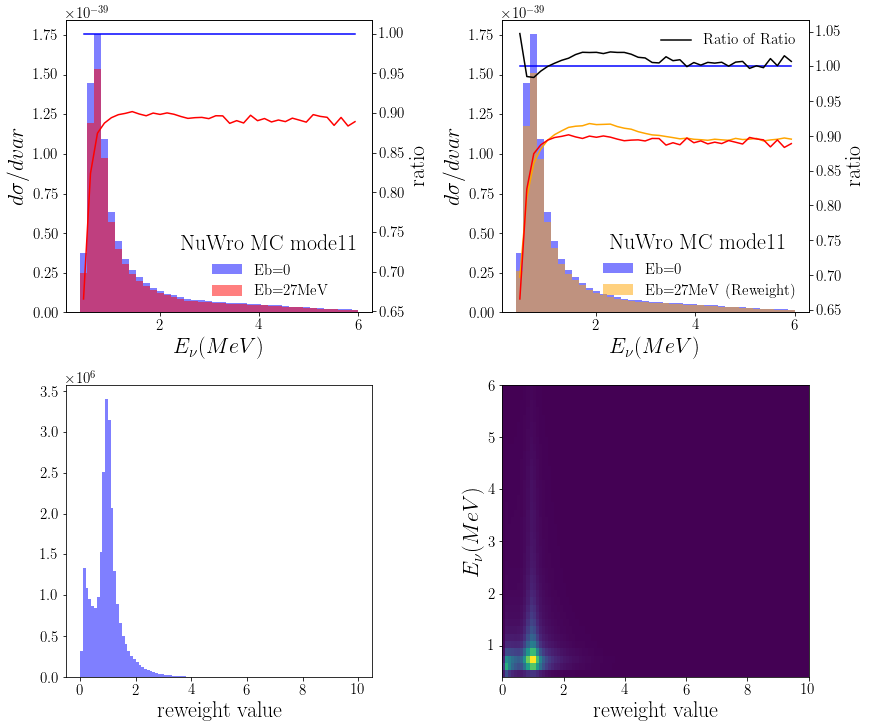

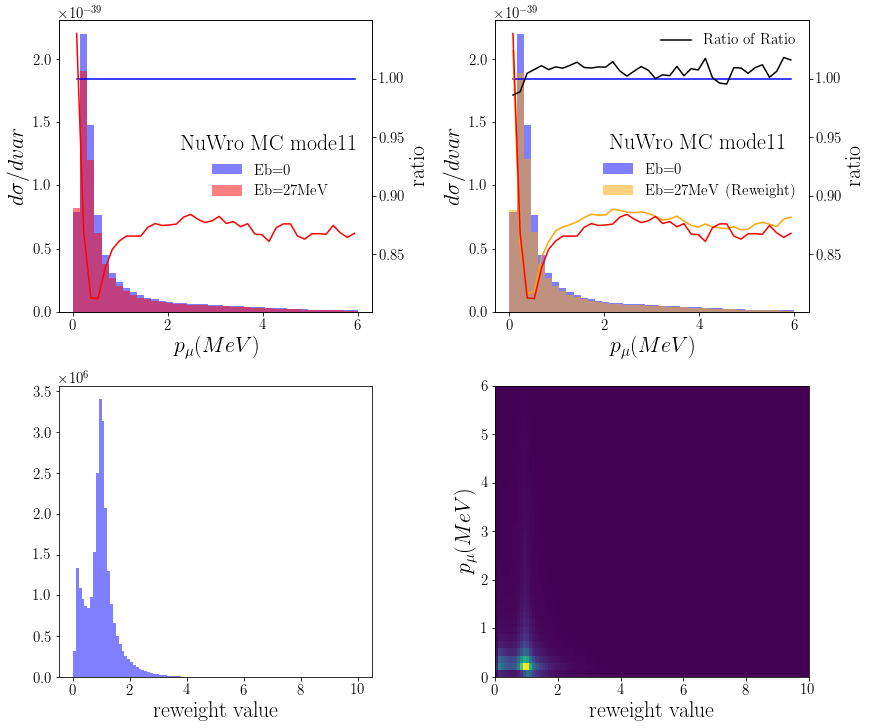

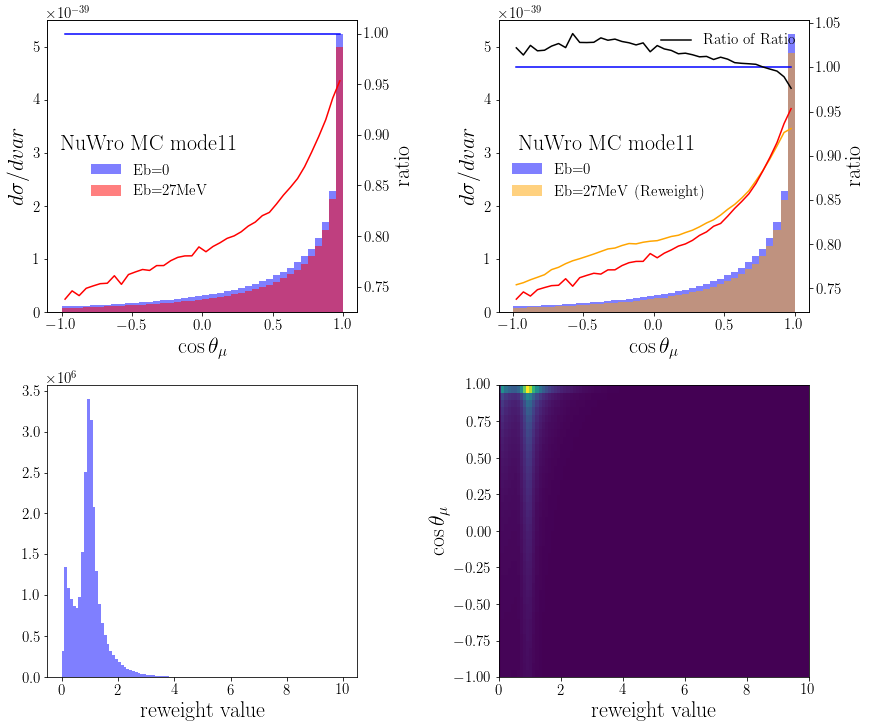

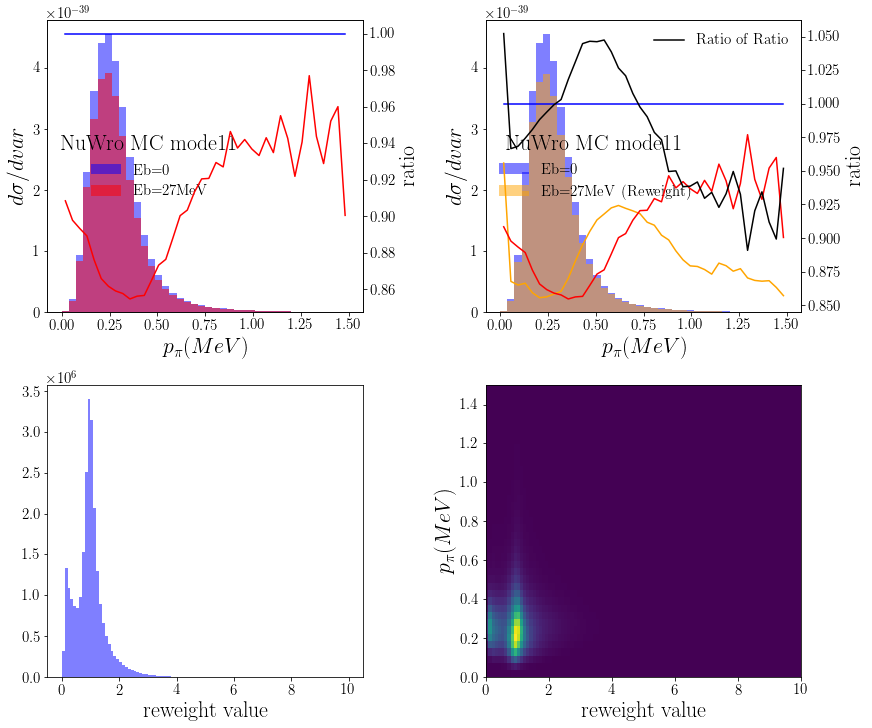

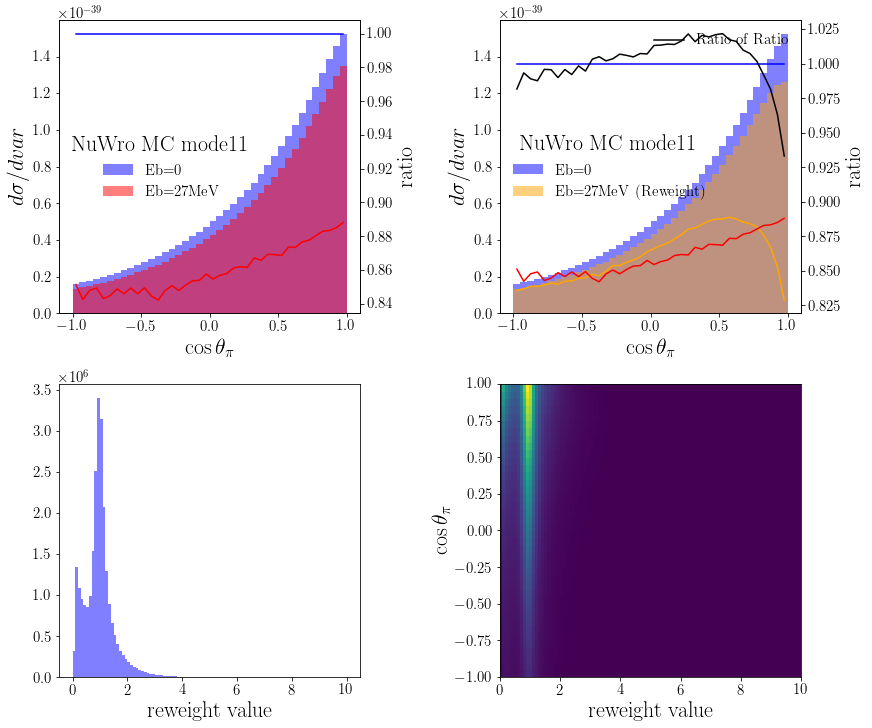

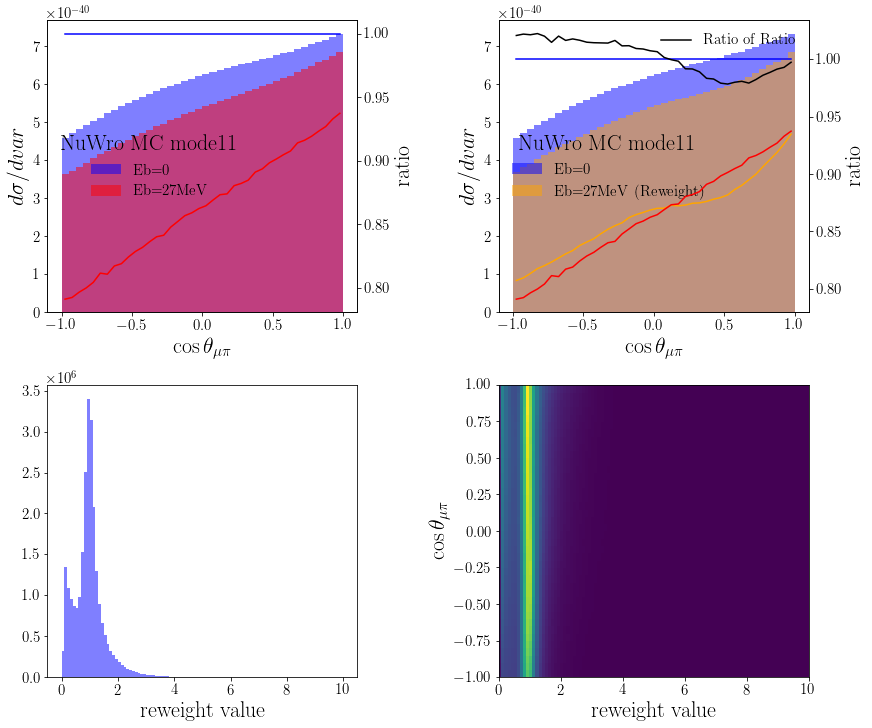

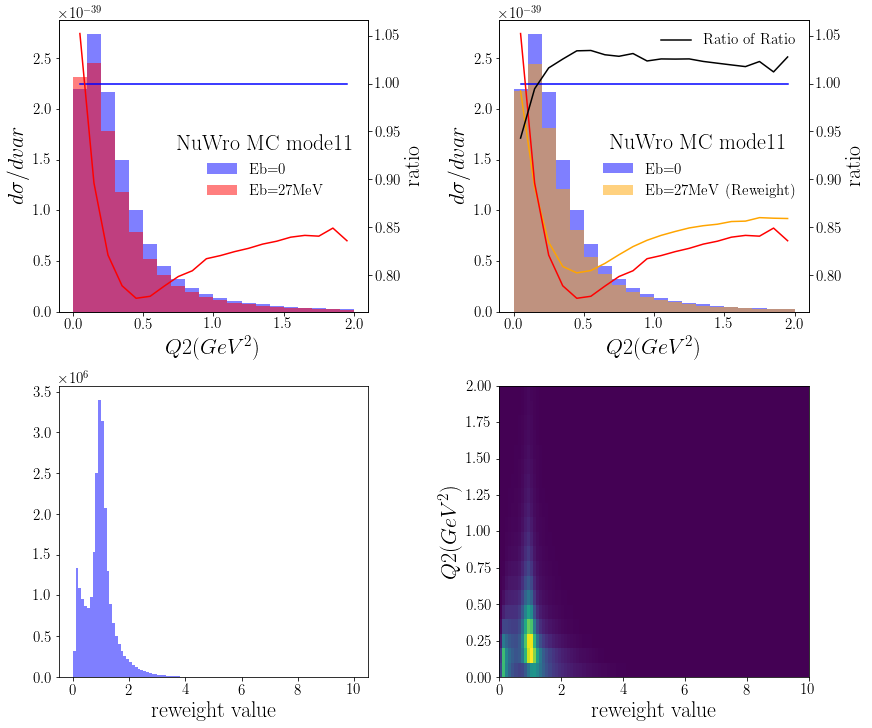

In [27]:
# make plots
for plotNum in range(7):

        w_norm=1./(np.sum(w_model)/len(w_model))*w27*len(array11_Eb27)/w0/len(array11_Eb0) #properly weight to normalize the reweighted events

        bins_Enu = np.linspace(0.4, 6, 41)
        bins_mumom = np.linspace(0, 6, 41)
        bins_mutheta = np.linspace(-1, 1, 41)
        bins_pimom = np.linspace(0, 1.500, 41)
        bins_pitheta = np.linspace(-1, 1, 41)
        bins_mupitheta = np.linspace(-1, 1, 41)
        bins_q2 = np.linspace(0, 2, 21)

        xlabel = (r"$E_\nu (MeV)$",r"$p_\mu (MeV)$",r"$\cos\theta_\mu$",r"$p_\pi (MeV)$",r"$\cos\theta_\pi$",r"$\cos\theta_{\mu\pi}$",r"$Q2 (GeV^2)$")

        bins_array = (bins_Enu,bins_mumom,bins_mutheta,bins_pimom,bins_pitheta,bins_mupitheta,bins_q2)
        legend_loc = ('lower right','center right','center left','center left','center left','center left','center right')

        bins_w= np.linspace(0, 10, 101)

        fig, ax = plt.subplots(2,
                            2,
                            figsize=(12, 10),
                            constrained_layout=True,
                            #sharey='row'
                            )

        binwidth = bins_array[plotNum][1]-bins_array[plotNum][0]

        ax[0,0].set_xlabel(xlabel[plotNum])
        ax[0,0].set_ylabel(r'$d\sigma/dvar$')
        h1=ax[0,0].hist(array11_Eb0[:,plotNum], bins=bins_array[plotNum], **plot_style_2, label='Eb=0',weights=w0/binwidth*np.ones(len(array11_Eb0)),color="blue")
        h2=ax[0,0].hist(array11_Eb27[:,plotNum], bins=bins_array[plotNum], **plot_style_2, label='Eb=27MeV',weights=w27/binwidth*np.ones(len(array11_Eb27)),color="red")
        legend = ax[0,0].legend(
                    title='NuWro MC mode11',
                    loc=legend_loc[plotNum],
                    frameon=False)
        plt.setp(legend.get_title(), multialignment='center')
        ax2 = ax[0,0].twinx()
        ax2.set_ylabel('ratio')
        bincenter = 0.5 * (h1[1][1:] + h1[1][:-1])
        plt.errorbar(bincenter, h1[0]/h1[0], fmt='-', color="blue")
        plt.errorbar(bincenter, h2[0]/h1[0], fmt='-', color="red")

        ax[0,1].set_xlabel(xlabel[plotNum])
        ax[0,1].set_ylabel(r'$d\sigma/dvar$')
        #ax[0,1].hist(array11_Eb0[:,2], bins=bins_mutheta, **plot_style_2, label='Eb=0',weights=array11_Eb0[:,6]/40000000/0.05)
        #ax[0,1].hist(array11_Eb27[:,2], bins=bins_mutheta, **plot_style_2, label='Eb=27MeV',weights=array11_Eb27[:,6]/40000000/0.05)
        h3=ax[0,1].hist(array11_Eb0[:,plotNum], bins=bins_array[plotNum], **plot_style_2, label='Eb=0',weights=w0/binwidth*np.ones(len(array11_Eb0)),color="blue")
        h4=ax[0,1].hist(array11_Eb0[:,plotNum], bins=bins_array[plotNum], **plot_style_2, label='Eb=27MeV (Reweight)',
                        weights=w0/binwidth*np.double(w_model)*w_norm,color="orange")
        ax4 = ax[0,1].twinx()
        ax4.set_ylabel('ratio')
        plt.errorbar(bincenter, h3[0]/h3[0], fmt='-', color="blue")
        plt.errorbar(bincenter, h4[0]/h3[0], fmt='-', color="orange")
        plt.errorbar(bincenter, h2[0]/h1[0], fmt='-', color="red")
        plt.errorbar(bincenter,  h4[0]/h3[0]/(h2[0]/h1[0]), fmt='-', color="black",label="Ratio of Ratio")
        legend = ax[0,1].legend(
                    title='NuWro MC mode11',
                    loc=legend_loc[plotNum],
                    frameon=False)
        ax4.legend(loc='upper right',frameon=False)
        plt.setp(legend.get_title(), multialignment='center')

        ax[1,0].set_xlabel('reweight value')
        ax[1,0].hist(w_model, bins=bins_w, **plot_style_2, label='Eb=0',color="blue")

        ax[1,1].set_xlabel('reweight value')
        ax[1,1].set_ylabel(xlabel[plotNum])
        ax[1,1].hist2d(w_model, array11_Eb0[:,plotNum], bins=(bins_w,bins_array[plotNum]))

        #ax[2,0].hist2d(array11_Eb0[:,0], array11_Eb0[:,1], bins=(bins_mumom,bins_mumom))

        #ax[2,1].hist2d(array11_Eb27[:,0], array11_Eb27[:,1], bins=(bins_mumom,bins_mumom))

        fig.show()